# How hashtags and captions change the perception and position of your brand on Instagram??
 ## Using NLP to correlate the use of hashtags and captions for different fashion brands.


<div>
<img src="just.jpg" width="600"/>
</div>

Hashtags are tags linked through different platforms. A proper hashtag is a visual component of an ad that can be used across different social networks to promote continuity of a campaign. 

Brands usually care about hashtags because these can reinforce a brand's position and promote customers' familiarity with it, which has an impact in the early stages of the buying cycle. But, can the use of hashtags (or captions) create an incorrect image of your brand? Let's say that you have a clothing brand in the category of designer, could the use of hashtags allude to another category of clothing? 

My goal is to use NLP to find how the use of captions and hashtags on Instagram correlate across different brands and brand categories. I will use clustering, a machine learning unsupervised classification where no a priori knowledge (such as samples of classes) is assumed to be available. 

The clustering task is grouping hashtags/captions in such a way that hashtags/captions in the same group (called a cluster) are more similar (in some sense) to each other than to those in other groups (clusters). Then I will analize how the clusters are associate with the different brands and categories, and how they affect engagement metrics.

Data obtained from the project https://arxiv.org/abs/1704.04137. In their data project they obtained 24,752 Instagram posts by 13,350 people on Instagram. The data collection was done over a month period in January 2015. And in all the posts renowned fashion brand is named in the hashtags.

The data includes:
- Basic information of the posts (brand name, brand category, likes, comments, user id, followings, followers, captions, hashtags, and creation time).
- Learned features from their model (identifies the kind of picture). 
- Learned features from Microsoft emotion API (identifies the emotion of the people that appears in the picture)


### First step: installing all the packages and getting the data

I'm using python and the sklearn packages for the data cleaning and machine leaning models. I'm using the nltk for the text processing.

I donwloaded the data in a pandas dataframe, I will be working with the hashtags and captions but I'm keeping the columns of followers, likes and comments because I want to compare the different engagement metrics for the brand, brandcategories and clusters.

My first step was a simple formating (removing non-alphabetical characters and lowercasing) in the name of the columns and in the columns that includes the brandnames.


In [1]:
from ig_plotting import * 
import nltk
from nltk.corpus import stopwords
import en_core_web_sm
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import AgglomerativeClustering
%matplotlib inline


#print('Loading words, spacy, punktd, stopwords')
nltk.download('words')
nlp = en_core_web_sm.load()
words = set(nltk.corpus.words.words())
nltk.download('stopwords')
#nltk.download('punkt')
print('done, now loading text and basic formating of columns name')


# Read dataset and format texts 
df = pd.read_csv(r'fashion data on instagram.csv', index_col=0).sample(frac=0.2)

#Formating column names, brand categories names and brand names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace('?', '')
df.brandname = df.brandname.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace('?', '')
df.brandcategory = df.brandcategory.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace('?', '')
text_df = df[['brandcategory', 'hashtags', 'caption', 'brandname', 'comments', 'likes','followers']].copy(deep=True)
text_df = text_df[~text_df['hashtags'].isnull()]
text_df = text_df[~text_df['caption'].isnull()]
text_df = text_df[~text_df['followers'].isnull()]
text_df = text_df[text_df['followers'] != 0]
text_df['comm_per_followers']=text_df['comments']/text_df['followers']
text_df['likes_per_followers']=text_df['likes']/text_df['followers']
text_df['comm_per_followers'].apply(lambda x: round(x, 2))
text_df['likes_per_followers'].apply(lambda x: round(x, 2))
brands = df.brandname.unique().tolist()

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\thalia\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


done, now loading text and basic formating of columns name


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\thalia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def cleaning(frame,col):
    """ 
    Function to clean text from a column in a data frame 
  
    This funtion removes non alphabethic characters,stop words and numerical characters and return text in lowers. 
  
    Parameters: 
    Data frame, text column 
  
    Returns: 
    obj clean text from column
  
    """
    newframe=frame.copy()  
    newframe=newframe[~newframe[col].isnull()]   
    punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}','#',"%"]
    stop_words = text.ENGLISH_STOP_WORDS.union(punc)
    newframe[col]=newframe[col].str.replace('\d+', '').str.replace('\W', ' ').str.lower().str.replace(r'\b(\w{1,3})\b', '')
    newframe['Cleantext'] = [' '.join([w for w in x.lower().split() if w not in stop_words]) for x in newframe[col].tolist()] 
    newframe['Cleantext'] =[' '.join(word for word in x.lower().split() if not word.startswith('uf')if not word.startswith('ue')if not word.startswith('u0')) for x in newframe[col].tolist()] 
    content = newframe['Cleantext'].values
    return content

stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text)]

clean_hashtags=cleaning(text_df,'hashtags')
clean_captions=cleaning(text_df,'caption')

## K means failure

Now I will conver my text to a matrix of TF-IDF features using TDIFVectorizer.

In [3]:
vectorizing = TfidfVectorizer(sublinear_tf=True,  min_df=200, norm='l2', 
                              ngram_range=(1, 1), tokenizer = tokenize)

%time clean_hashtags_vector = vectorizing.fit_transform(clean_hashtags) #fit the vectorizer
#terms = vectorizing.get_feature_names()

Wall time: 14.1 s


In [4]:
clfhash = LocalOutlierFactor(n_neighbors=50)
clfhash.fit_predict(clean_hashtags_vector.toarray())
text_df['outlier_factor_hash'] = clfhash.negative_outlier_factor_

C:\Users\thalia\Anaconda3\lib\site-packages\sklearn\neighbors\lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


In [5]:
text_df['outlier_factor_hash']
print(len(text_df))
data=text_df[text_df['outlier_factor_hash']>-5]
print(len(data))
clean_hashtags_vector = vectorizing.fit_transform(cleaning(data,'hashtags'))
#16419 con 50

24543
13636


Next, we need to know the clusters that we want our data to be split to. We will again use the scipy library to create the dendrograms for our dataset. Execute the following script to do so:
In the script above we import the hierarchy class of the scipy.cluster library as shc. The hierarchy class has a dendrogram method which takes the value returned by the linkage method of the same class. The linkage method takes the dataset and the method to minimize distances as parameters. We use 'ward' as the method since it minimizes then variants of distances between the clusters.
Basically the horizontal line is a threshold, which defines the minimum distance required to be a separate cluster. If we draw a line further down, the threshold required to be a new cluster will be decreased and more clusters will be formed as see in the image below:

In [6]:
#import scipy.cluster.hierarchy as shc

#plt.figure(figsize=(10, 7))
#plt.title("Hashtag Dendograms")
#dend = shc.dendrogram(shc.linkage(clean_hashtags_vector.toarray(), method='ward'))

If we draw a horizontal line that passes through longest distance without a horizontal line, we got 8 clusters.

In [7]:
cluster = AgglomerativeClustering(n_clusters=8, affinity='euclidean', linkage='ward')
cluster.fit_predict(clean_hashtags_vector.toarray())
data['cluster_hashtags'] = cluster.labels_


C:\Users\thalia\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


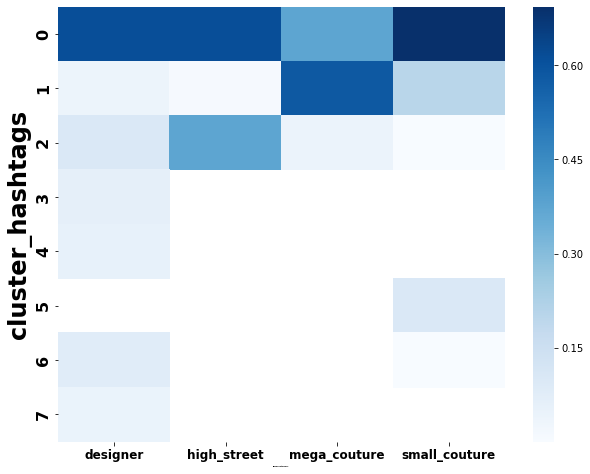

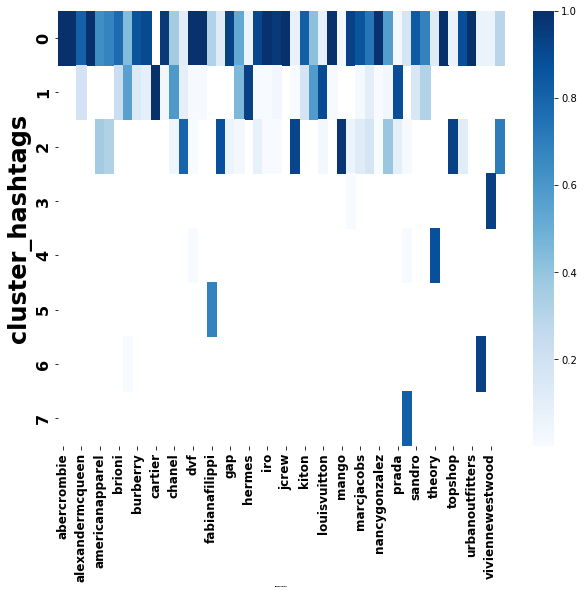

In [8]:
plotclusterscorr(data,'brandcategory','cluster_hashtags')
plotclusterscorr(data,'brandname','cluster_hashtags')

In [9]:
list1=[50,100,500,1000,2000,10000]
dict_clusters={0:"gold", 1:'darkcyan', 2:'plum', 3:'royalblue', 4:'salmon', 5:'pink', 6:'steelblue', 7:'orchid'}
interact(plotjoint, df=fixed(data), clusters=fixed('cluster_hashtags'), color_code=fixed(dict_clusters), x_col=fixed('likes'), 
         y_col=fixed('comments'), xlim=list1, ylim=list1)

interactive(children=(Dropdown(description='xlim', options=(50, 100, 500, 1000, 2000, 10000), value=50), Dropd…

<function ig_plotting.plotjoint(df, clusters, color_code, x_col, y_col, xlim, ylim)>

In [10]:
data.head()

,brandcategory,hashtags,caption,brandname,comments,likes,followers,comm_per_followers,likes_per_followers,outlier_factor_hash,cluster_hashtags
UserId,,,,,,,,,,,
1171594777274371222_176762322,high_street,"teen, model, brunette, selfie, hollister, snap...","Gotta run, but first, let me take selfie. Me...",abercrombie,0,94,2300.0,0.000000,0.040870,-1.093581,0
1171508187966229230_2797323089,high_street,"abercrombieandfitch, shopping, love, hollister...",#love #shopping #shoppen #hollister #abercro...,abercrombie,1,9,456.0,0.002193,0.019737,-1.069078,0
1171484116965155949_144838608,high_street,"abercrombie, applewatch, apple, applestyle",No Sugar Day#apple #applewatch #applestyle #...,abercrombie,1,7,166.0,0.006024,0.042169,-0.983748,0
1171234577662370393_402613607,high_street,"savemore, abercrombieandfitch, shoplocal, aber...","u\""\""Women's Abercrombie and Fitch Flannels ...",abercrombie,0,7,1939.0,0.000000,0.003610,-0.983748,0
1171232911055059848_35033005,high_street,"deco, gillyhicks, room, victoriassecret, bodys...","u\""\""Room lookin' on point. #lights\""\"",",abercrombie,1,7,1244.0,0.000804,0.005627,-1.056162,0


In [11]:
%time clean_captions_vector = vectorizing.fit_transform(clean_captions)

clfcapt = LocalOutlierFactor(n_neighbors=50)
clfcapt.fit_predict(clean_captions_vector.toarray())
text_df['outlier_factor_capt'] = clfcapt.negative_outlier_factor_

Wall time: 7.03 s


C:\Users\thalia\Anaconda3\lib\site-packages\sklearn\neighbors\lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


In [12]:
text_df['outlier_factor_capt']
print(len(text_df))
data=text_df[text_df['outlier_factor_capt']>-5]
print(len(data))
clean_captions_vector = vectorizing.fit_transform(cleaning(data,'caption'))
#16419 con 50

24543
10378


In [13]:
#plt.figure(figsize=(10, 7))
#plt.title("Caption Dendograms")
#dend = shc.dendrogram(shc.linkage(clean_captions_vector.toarray(), method='ward'))

If we draw a horizontal line that passes through longest distance without a horizontal line, we get 5 clusters as shown in the following figure:

In [14]:
clustercap = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
clustercap.fit_predict(clean_captions_vector.toarray())
data['cluster_captions'] = clustercap.labels_


C:\Users\thalia\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


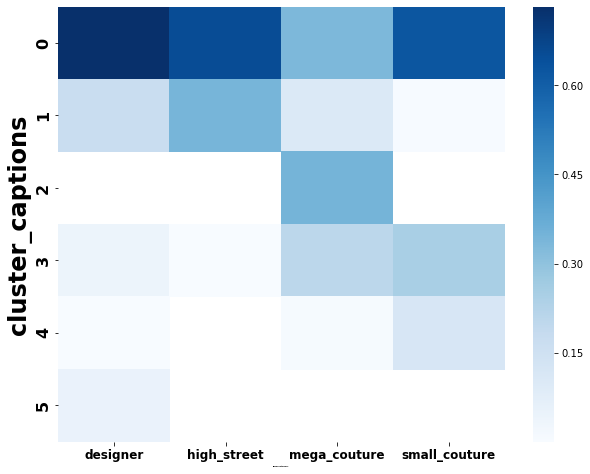

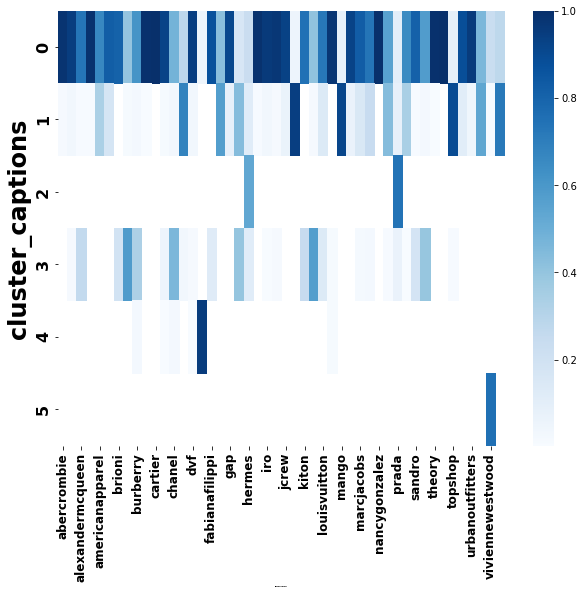

In [15]:
plotclusterscorr(data,'brandcategory','cluster_captions')
plotclusterscorr(data,'brandname','cluster_captions')